In [1]:
# !pip install datasets
# !pip install peft

In [2]:
import os
# disable tokenizers’ internal parallelism (avoids deadlocks after forking)
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, accuracy_score

from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer
from peft import LoraConfig, TaskType, get_peft_model
from scipy.special import softmax

/users/eleves-a/2021/abasse.dabere/Desktop/ChatGPT-Generated-Abstracts-Detection/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [4]:
import sys
sys.path.append("../scripts/")
from utils import plot_confusion_matrix, print_metrics

In [5]:
# Get Data
data_path = '../data/with_features/'
train_data = pd.read_csv(f'{data_path}train.csv')
test_data = pd.read_csv(f'{data_path}test.csv')

In [6]:
train_data.columns

Index(['abstract', 'label', 'num_characters', 'word_count', 'sentence_count',
       'mean_sentence_length', 'burstiness', 'stop_words_ratio',
       'vocabulary_size', 'ttr', 'preprocessed_abstract', 'tfidf_method',
       'tfidf_approach', 'tfidf_proposed', 'tfidf_paper', 'tfidf_study',
       'tfidf_analysis', 'tfidf_using', 'tfidf_application', 'tfidf_potential',
       'tfidf_performance', 'tfidf_network', 'tfidf_algorithm',
       'tfidf_feature', 'tfidf_learning', 'tfidf_data', 'tfidf_model',
       'tfidf_control', 'tfidf_information', 'tfidf_accuracy',
       'tfidf_technique', 'flesch', 'noun_prop', 'det_prop', 'adj_prop',
       'aux_prop', 'pron_prop', 'adv_prop', 'punct_prop', 'adp_prop', 'ppl'],
      dtype='object')

## `Human vs Mix`

In [7]:
# Keep only human and mix labels
Z_train = train_data[train_data['label'].isin(['human', 'mix'])].copy()
Z_test = test_data[test_data['label'].isin(['human', 'mix'])].copy()

Z_train['label'] = Z_train['label'].map({'human': 0, 'mix': 1})
Z_test['label'] = Z_test['label'].map({'human': 0, 'mix': 1})

# Split the data into human and mix
train_h = Z_train[Z_train['label'] == 0]
train_f = Z_train[Z_train['label'] == 1]
test_h  = Z_test[Z_test['label']  == 0]
test_f  = Z_test[Z_test['label']  == 1]

# Number of samples in the minority class
n_train = min(len(train_h), len(train_f))
n_test  = min(len(test_h),  len(test_f))

# Undersample the majority class
train_h_down = train_h.sample(n_train, replace=False, random_state=42)
train_f_down = train_f.sample(n_train, replace=False, random_state=42)
test_h_down  = test_h.sample(n_test,  replace=False, random_state=42)
test_f_down  = test_f.sample(n_test,  replace=False, random_state=42)

# Concatenate the undersampled data
Z_train = pd.concat([train_h_down, train_f_down], axis=0)
Z_test  = pd.concat([test_h_down, test_f_down], axis=0)

Z_train = Z_train[['abstract', 'label']].reset_index(drop=True)
Z_test = Z_test[['abstract', 'label']].reset_index(drop=True)

print(f"Train shape: {Z_train.shape}")
print(f"Test shape: {Z_test.shape}")

Train shape: (7222, 2)
Test shape: (1806, 2)


In [8]:
# Convert to HuggingFace Dataset

raw_datasets = DatasetDict({
    "train": Dataset.from_pandas(Z_train),
    "validation": Dataset.from_pandas(Z_test)
})

In [9]:
# Tokenizer & base model for sequence classification
MODEL_NAME = "distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [10]:
base_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# Configure LoRA
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=32,
    lora_alpha=32,
    lora_dropout=0.1,
)

model = get_peft_model(base_model, lora_config)

In [ ]:
model.config.id2label   = {0: "human", 1: "mix"}
model.config.label2id   = {"human": 0, "mix": 1}

In [13]:
# Preprocessing: tokenize abstracts
def preprocess_fn(examples):
    return tokenizer(examples["abstract"], truncation=True, padding=False)

tokenized_datasets = raw_datasets.map(
    preprocess_fn,
    batched=True,
    remove_columns=[c for c in raw_datasets["train"].column_names if c != "label"],
)

tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"]
)

Map:   0%|          | 0/7222 [00:00<?, ? examples/s]

Map:   0%|          | 0/1806 [00:00<?, ? examples/s]

In [14]:
# Data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer)

In [15]:
# Metrics computation

from sklearn.metrics import f1_score, precision_score, recall_score


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    probs = softmax(logits, axis=-1)[:, 1]

    acc = accuracy_score(labels, preds)
    auc = roc_auc_score(labels, probs)
    return {
        "ACC": acc,
        "AUC": auc,
    }

In [16]:
# Training arguments
training_args = TrainingArguments(
    output_dir="../lora_output/lora-distilroberta-output",
    do_train=True,
    do_eval=True,
    eval_strategy="steps",
    save_strategy="steps",

    eval_steps=50,
    save_steps=50,
    logging_steps=50,

    learning_rate=1e-4,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    num_train_epochs=20,
    weight_decay=0.01,

    load_best_model_at_end=True,
    metric_for_best_model="AUC",
)

In [17]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/tmp/ipykernel_2160767/1930133925.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [18]:
# add label names for the trainer
trainer.label_names = ["labels"]

In [19]:
# Fine-tuning
trainer.train()

Step,Training Loss,Validation Loss,Acc,Auc
50,0.687100,0.671227,0.584164,0.707995
100,0.639800,0.686165,0.589147,0.746938
150,0.598300,0.760086,0.577519,0.780338
200,0.557700,0.909779,0.570321,0.794817
250,0.543100,0.825342,0.608527,0.811799
300,0.527700,0.891003,0.596346,0.816927
350,0.506700,0.932612,0.588594,0.823798
400,0.490500,0.796671,0.615725,0.830543
450,0.483900,0.950660,0.586379,0.833298
500,0.479800,0.891864,0.618494,0.840479


TrainOutput(global_step=1140, training_loss=0.4867938510158606, metrics={'train_runtime': 1483.8245, 'train_samples_per_second': 97.343, 'train_steps_per_second': 0.768, 'total_flos': 1.5281489776050432e+16, 'train_loss': 0.4867938510158606, 'epoch': 20.0})

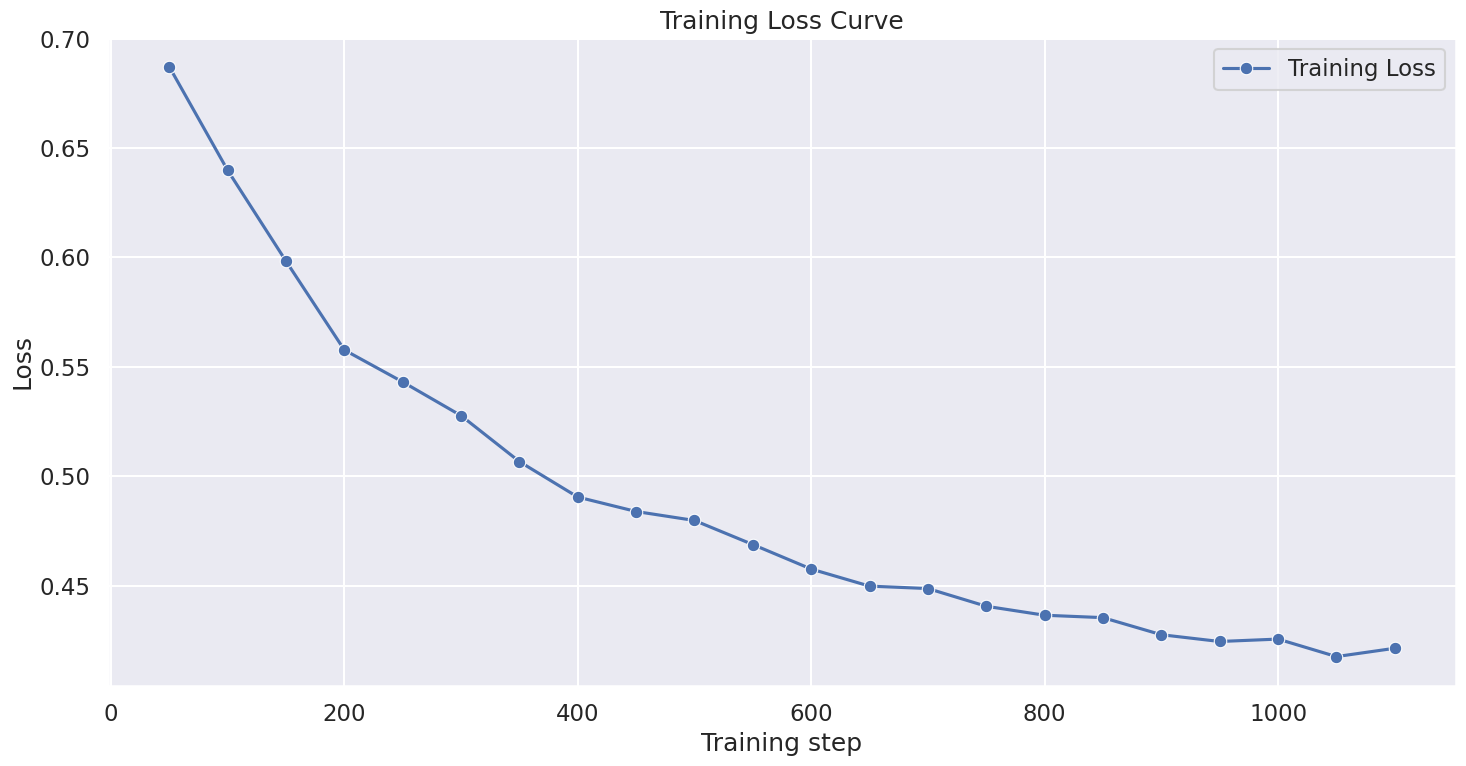

In [20]:
# Plotting training loss
logs = trainer.state.log_history
steps = [entry["step"] for entry in logs if "loss" in entry]
train_losses = [entry["loss"] for entry in logs if "loss" in entry]
df = pd.DataFrame({"step": steps, "loss": train_losses})

sns.set_theme(style="darkgrid", context="talk")
plt.figure(figsize=(15, 8))
sns.lineplot(data=df, x="step", y="loss", marker="o", label="Training Loss")
plt.xlabel("Training step")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
# Evaluation
pred_output = trainer.predict(tokenized_datasets["validation"])
y_proba = softmax(pred_output.predictions , axis=-1)[:, 1]

y_pred = pred_output.predictions.argmax(-1)
y_test = tokenized_datasets["validation"]["labels"]

In [22]:
# print Accuracy and AUC
print_metrics(np.array(y_test), y_pred, y_proba)

Accuracy: 0.6218
AUC: 0.8492


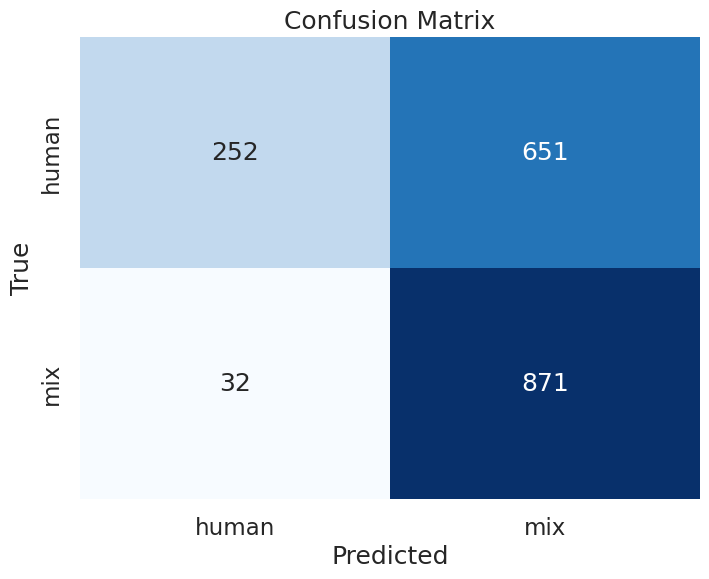

In [26]:
# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, labels=['human', 'mix'])

In [25]:
# Save
model.save_pretrained("../models/human_vs_mix/lora-distilroberta-model")
tokenizer.save_pretrained("../models/human_vs_mix/lora-distilroberta-tokenizer")

('../models/human_vs_mix/lora-distilroberta-tokenizer/tokenizer_config.json',
 '../models/human_vs_mix/lora-distilroberta-tokenizer/special_tokens_map.json',
 '../models/human_vs_mix/lora-distilroberta-tokenizer/vocab.json',
 '../models/human_vs_mix/lora-distilroberta-tokenizer/merges.txt',
 '../models/human_vs_mix/lora-distilroberta-tokenizer/added_tokens.json',
 '../models/human_vs_mix/lora-distilroberta-tokenizer/tokenizer.json')